In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.units as u

from astropy.coordinates import SkyCoord
from astropy import utils, io
from dl import authClient as ac, queryClient as qc
from dl.helpers.utils import convert
from pyvo.dal import sia
# from datalab_utils import *

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
fig_dir = "/dlusers/adriansh/work/analyses/plots/strings/"

In [2]:
def plot_lightcurve_excursion(lightcurve_df, object_id, fig_dir="/dlusers/adriansh/work/analyses/plots/strings/", savefig=False):
    colors = np.array(["tab:blue", "tab:green", "yellow", "tab:orange", "tab:red", "tab:brown"])
    filters = np.array(['u', 'g', 'r', 'i', 'z', 'Y'])
    mask_filters = np.array([lightcurve_df["filter"] == f for f in filters])
    fig, ax = plt.subplots(figsize=(12, 9))

    object_id_str = str(object_id).replace('.', '-')
    mask_id = lightcurve_df["objectid"] == object_id
    source_lc_df = lightcurve_df.loc[mask_id]
    min_mjd = source_lc_df["mjd"].astype(int).min()
    filters_with_excursion = source_lc_df.loc[source_lc_df["excursion"], "filter"]
    
    for f in filters_with_excursion:
        m = filters == f
        c = colors[m][0]
        mask_filter = mask_filters[m]
        mask = mask_id & mask_filter
        mask_exc = mask & lightcurve_df["excursion"]
        
        lightcurve_full = lightcurve_df.loc[mask]

        lightcurve_exc = lightcurve_df.loc[mask_exc]
        
        vals = lightcurve_df.loc[(mask & ~lightcurve_df["excursion"]), "mag_auto"].values
        weights = (lightcurve_df.loc[(mask & ~lightcurve_df["excursion"]), "magerr_auto"].values)**-2
        w_mean = weighted_mean(vals, weights)
        w_sigma = weighted_std(vals, weights)
        delta = lightcurve_exc["mag_auto"].values[0] - w_mean
        n_sigma = delta / (lightcurve_exc["magerr_auto"].values[0] + w_sigma)
        ratio = np.power(10, -0.4 * delta)

        ax.errorbar(lightcurve_full["mjd"] - min_mjd, lightcurve_full['mag_auto'], 
                    yerr=lightcurve_full["magerr_auto"],
                    marker='.', ms=8, capsize=5, color=c, ls="None", alpha=0.3)

        ax.errorbar(lightcurve_exc["mjd"] - min_mjd, lightcurve_exc['mag_auto'], yerr=lightcurve_exc["magerr_auto"],
                    marker='.', ms=8, capsize=5, color=c, 
                    label=fr"{f}:  {ratio:0.2f}, {n_sigma:0.2f}$\sigma$", ls="None")
        
        ax.axhline(w_mean, color=c, linestyle='--')
        ax.axhspan(w_mean - w_sigma, w_mean + w_sigma, color=c, alpha=0.3)

    ax.set_xlabel(f'MJD - {min_mjd}', fontsize=20)
    ax.set_ylabel('Automatic Aperture Magnitude', fontsize=20)
    ax.legend(fontsize=18)
    ax.tick_params(labelsize=18)
    ax.set_title(f"Object {object_id}", fontsize=22)
    ax.invert_yaxis()
    plt.show(fig)
    
    if savefig:
        fig.savefig(f"{fig_dir}nsc_dr2_{object_id_str}_kde_detection_lightcurve.png")
    plt.close(fig)

def plot_lightcurve_basic(lightcurve_df, object_id, fig_dir="/dlusers/adriansh/work/analyses/plots/strings/", savefig=False):
    colors = np.array(["tab:blue", "tab:green", "yellow", "tab:orange", "tab:red", "tab:brown"])
    filters = np.array(['u', 'g', 'r', 'i', 'z', 'Y'])
    mask_filters = np.array([lightcurve_df["filter"] == f for f in filters])
    fig, ax = plt.subplots(figsize=(12, 9))

    object_id_str = str(object_id).replace('.', '-')
    mask_id = lightcurve_df["objectid"] == object_id
    source_lc_df = lightcurve_df.loc[mask_id]
    min_mjd = source_lc_df["mjd"].astype(int).min()
    filters_lc = source_lc_df["filter"].unique()
    
    for f in filters_lc:
        m = filters == f
        c = colors[m][0]
        mask_filter = mask_filters[m]
        mask = mask_id & mask_filter
        lightcurve = lightcurve_df.loc[mask]

        ax.errorbar(lightcurve["mjd"] - min_mjd, lightcurve['mag_auto'], 
                    yerr=lightcurve["magerr_auto"],
                    marker='.', ms=8, capsize=5, color=c, ls="None", label=f)

    ax.set_xlabel(f'MJD - {min_mjd}', fontsize=20)
    ax.set_ylabel('Automatic Aperture Magnitude', fontsize=20)
    ax.legend(fontsize=18)
    ax.tick_params(labelsize=18)
    ax.set_title(f"Object {object_id}", fontsize=22)
    ax.invert_yaxis()
    plt.show(fig)
    
    if savefig:
        fig.savefig(f"{fig_dir}nsc_dr2_{object_id_str}_lightcurve.png")
    plt.close(fig)

def aggregator_weighted_std(df, mag_column="mag_auto", magerr_column="magerr_auto"):
    samples = df[mag_column].values
    weights = np.power(df[magerr_column].values, -2)
    result = datalab_utils.weighted_std(samples, weights)
    return result

In [3]:
lmc_center = SkyCoord("05h23m34s", "−69d45.4m")
lmc_ra = lmc_center.ra.deg
lmc_dec = lmc_center.dec.deg
search_radius = 5
n_detections = 10

In [16]:
object_query = f"""
SELECT id 
    FROM nsc_dr2.object
        WHERE 't' = Q3C_RADIAL_QUERY(ra, dec, {lmc_ra}, {lmc_dec}, {search_radius})
        AND class_star > 0.9
    LIMIT 10000
"""

query = f"""
SELECT M.objectid, M.filter, M.mag_auto, M.magerr_auto, M.mjd, M.exposure, E.exptime
    FROM 
    (SELECT * 
        FROM nsc_dr2.meas
        WHERE objectid IN ({object_query})
        AND filter != 'VR' AND filter != 'Y') AS M
    INNER JOIN nsc_dr2.exposure AS E
        ON M.exposure = E.exposure
"""

qc.query(sql=query, out="mydb://lightcurves")

'OK'

In [7]:
q = """
SELECT *
    FROM mydb://lightcurves
"""
lightcurve_df = qc.query(sql=q, fmt="pandas")

In [4]:
lightcurve_df = pd.read_feather("/dlusers/adriansh/work/analyses/results/strings/nsc_lightcurve_df.feather")
lensing_df = pd.read_feather("/dlusers/adriansh/work/analyses/results/strings/nsc_lensing_df.feather")

In [5]:
import importlib
import datalab_utils
importlib.reload(datalab_utils)

<module 'datalab_utils' from '/home/jail/dlusers/adriansh/work/stringScratch/datalab_utils.py'>

In [6]:
%%time
ids = lightcurve_df["objectid"].unique()
dfs = []
bw = 2.5 * np.log10(2) / 4

for oid in ids:
    m_id = lightcurve_df["objectid"] == oid
    cluster_labelled_df = datalab_utils.cluster_label_dataframe(lightcurve_df.loc[m_id], kde_bandwidth=bw)

    if cluster_labelled_df is None:
        continue
    else:
        lensing_result = datalab_utils.analyze_lensing_window(cluster_labelled_df)

        if lensing_result is None:
            continue
        else:
            lensing_window = lensing_result["time_window"]
            n_samples = lensing_result["n_samples"]
            lensing_filters = lensing_result["filters"]
            event_start = lensing_window[0]
            event_end = lensing_window[1]
            data = [oid, event_start, event_end, n_samples, lensing_filters]
            d = pd.DataFrame([data], columns=["objectid", "event_start", "event_end", "n_samples", "filters"])
            dfs.append(d)

lensing_df = pd.concat(dfs, ignore_index=True)

CPU times: user 5min 40s, sys: 292 ms, total: 5min 41s
Wall time: 5min 41s


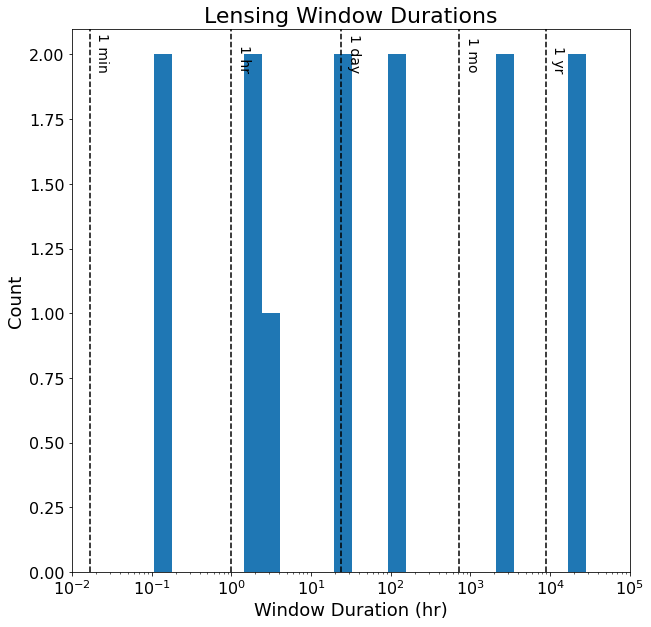

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
noteable_times = (np.array([60, 60 * 60, 60 * 60 * 24, 60 * 60 * 24 * 30, 60 * 60 * 24 * 365]) * u.s).to(u.hr).value
time_labels = ["1 min", "1 hr", "1 day", "1 mo", "1 yr"]
h_data = (pd.to_numeric(lensing_df["event_end"]) - pd.to_numeric(lensing_df["event_start"])).values * u.day
h_data = h_data.to(u.hr).value
bins = np.geomspace(h_data.min(), 1.5 * h_data.max(), num=25)

ax.hist(h_data, bins=bins)
ax.set_xlabel("Window Duration (hr)", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Lensing Window Durations", fontsize=22)
ax.set_xscale("log")
ax.tick_params(labelsize=16)
ax.set_xlim((1e-2, 1e5))
blended_transform = ax.get_xaxis_transform()
axis_transform = ax.transAxes
axis_transform_inverse = axis_transform.inverted()

for t, l in zip(noteable_times, time_labels):
    ax.axvline(t, ls="--", color='k')
    (x, y) = axis_transform_inverse.transform(blended_transform.transform((t, 0.925)))
    ax.text(x+0.01, y, l, fontsize=14, transform=axis_transform, rotation=-90)
    
plt.show(fig)
# fig.savefig(f"{fig_dir}lensing_window_durations_histogram.png")

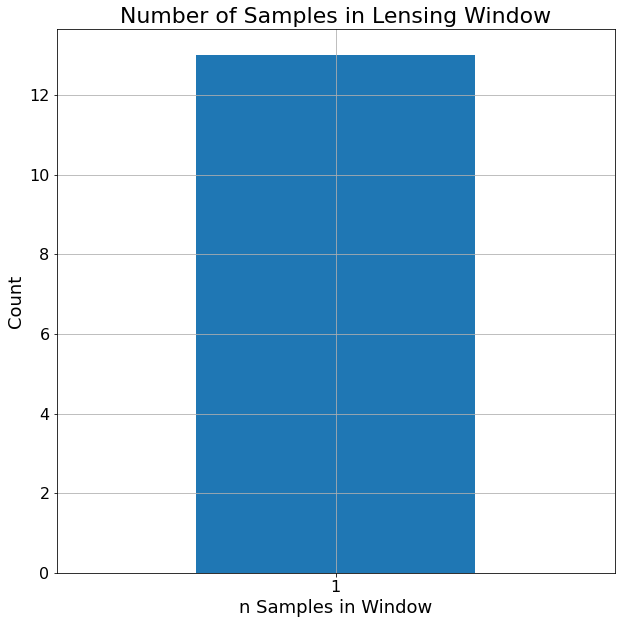

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
lensing_df["n_samples"].value_counts().plot.bar(ax=ax)    
ax.set_xlabel("n Samples in Window", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Number of Samples in Lensing Window", fontsize=22)
ax.tick_params(labelsize=16)
ax.tick_params(axis='x', labelrotation=0)
ax.grid(visible=True)
    
plt.show(fig)
# fig.savefig(f"{fig_dir}lensing_window_n_samples.png")

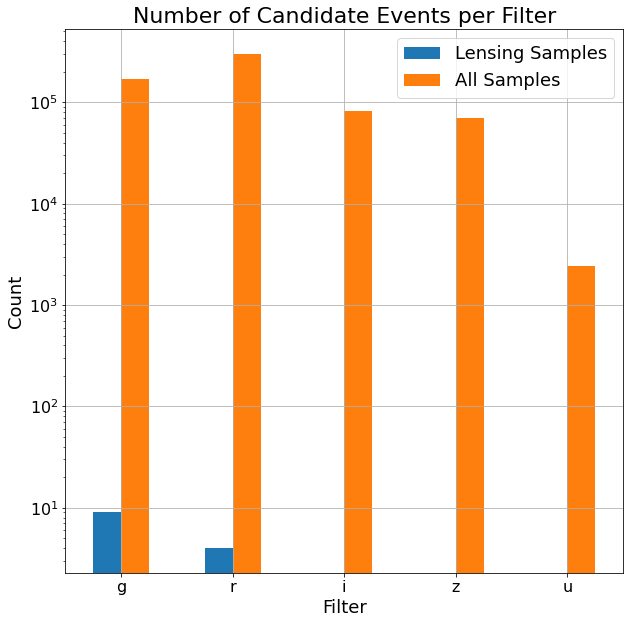

In [11]:
lensing_filter_counts = lensing_df["filters"].value_counts()
all_filter_counts = lightcurve_df["filter"].value_counts()
filter_counts_df = pd.concat([lensing_filter_counts, all_filter_counts], axis=1)
filter_counts_df.rename(columns={"filters": "Lensing Samples", "filter": "All Samples"}, inplace=True)

fig, ax = plt.subplots(figsize=(10, 10))
filter_counts_df.plot.bar(ax=ax)
ax.set_xlabel("Filter", fontsize=18)
ax.set_ylabel("Count", fontsize=18)
ax.set_title("Number of Candidate Events per Filter", fontsize=22)
ax.tick_params(labelsize=16)
ax.tick_params(axis='x', labelrotation=0)
ax.grid(visible=True)
ax.set_yscale("log")
ax.legend(fontsize=18)
    
plt.show(fig)
fig.savefig(f"{fig_dir}lensing_window_filter_distribution.png")

In [12]:
weighted_stds = lightcurve_df.groupby(["objectid", "filter"]).apply(aggregator_weighted_std)

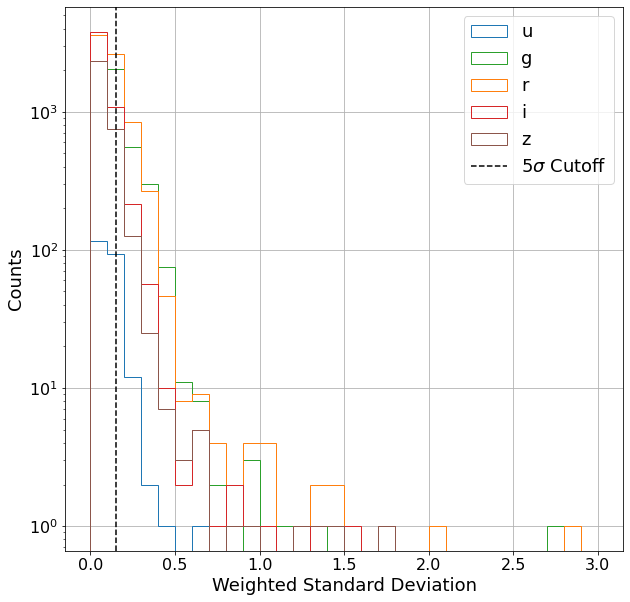

In [13]:
colors = np.array(["tab:blue", "tab:green", "tab:orange", "tab:red", "tab:brown"])
filters = np.array(['u', 'g', 'r', 'i', 'z'])
bins = np.linspace(0, 3, num=31)

fig, ax = plt.subplots(figsize=(10, 10))

for f, c in zip(filters, colors):
    weighted_stds[:, f].hist(grid=True, ax=ax, stacked=True, histtype="step", 
                             label=f, log=True, color=c, bins=bins)

ax.axvline(np.log10(2) / 2, color='k', linestyle="--", label=r"5$\sigma$ Cutoff")
ax.tick_params(labelsize=16)
ax.set_xlabel("Weighted Standard Deviation", fontsize=18)
ax.set_ylabel("Counts", fontsize=18)
ax.legend(loc="upper right", fontsize=18)
plt.show(fig)

In [83]:
%%time
q = f"""
SELECT urms, grms, rrms, irms, zrms, ndetu, ndetg, ndetr, ndeti, ndetz
    FROM nsc_dr2.object
        WHERE 't' = Q3C_RADIAL_QUERY(ra, dec, {lmc_ra}, {lmc_dec}, {search_radius})
        AND class_star > 0.9
        AND 
        CASE 
            WHEN ndetu > {n_detections} THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndetg > {n_detections} THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndetr > {n_detections} THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndeti > {n_detections} THEN 1 
            ELSE 0 
        END +
        CASE 
            WHEN ndetz > {n_detections} THEN 1 
            ELSE 0 
        END >= 3
    LIMIT 1000000
"""

rms_df = qc.query(sql=q, fmt="pandas")

CPU times: user 1.4 s, sys: 631 ms, total: 2.03 s
Wall time: 2min 15s


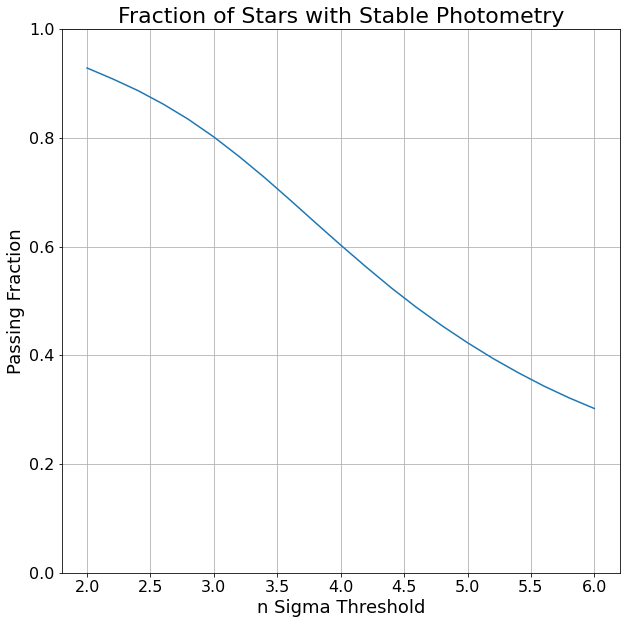

In [93]:
cond = rms_df[rms_df.columns[5:]] > n_detections
m = pd.DataFrame(data=False, index=rms_df.index, columns=rms_df.columns)
x = np.linspace(2, 6, num=21)
y = []

for xx in x:
    m[m.columns[5:]] = True
    m[m.columns[:5]] = cond

    rms_df.where(m, other=0, inplace=True)
    m2 = (rms_df[rms_df.columns[:5]] < 2.5 * np.log10(1.7) / xx).all(axis=1)

    y.append(len(rms_df.loc[m2]) / len(rms_df))

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x, y)
ax.tick_params(labelsize=16)
ax.set_xlabel("n Sigma Threshold", fontsize=18)
ax.set_ylabel("Passing Fraction", fontsize=18)
ax.grid(visible=True)
ax.set_title("Fraction of Stars with Stable Photometry", fontsize=22)
ax.set_ylim((0, 1))
plt.show(fig)
fig.savefig(f"{fig_dir}stable_photometry_fraction.png")

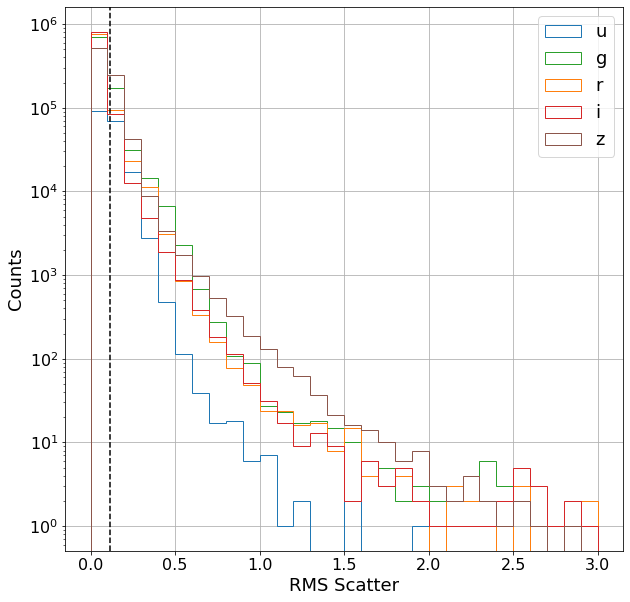

In [47]:
filters = np.array(['u', 'g', 'r', 'i', 'z'])
bins = np.linspace(0, 3, num=31)

fig, ax = plt.subplots(figsize=(10, 10))

for f, c in zip(filters, colors):
    rms_df[f"{f}rms"].hist(grid=True, ax=ax, stacked=True, histtype="step", 
                           label=f, log=True, color=c, bins=bins)

ax.axvline(np.log10(1.7) / 2, color='k', linestyle="--")
ax.tick_params(labelsize=16)
ax.set_xlabel("RMS Scatter", fontsize=18)
ax.set_ylabel("Counts", fontsize=18)
ax.legend(loc="upper right", fontsize=18)
plt.show(fig)

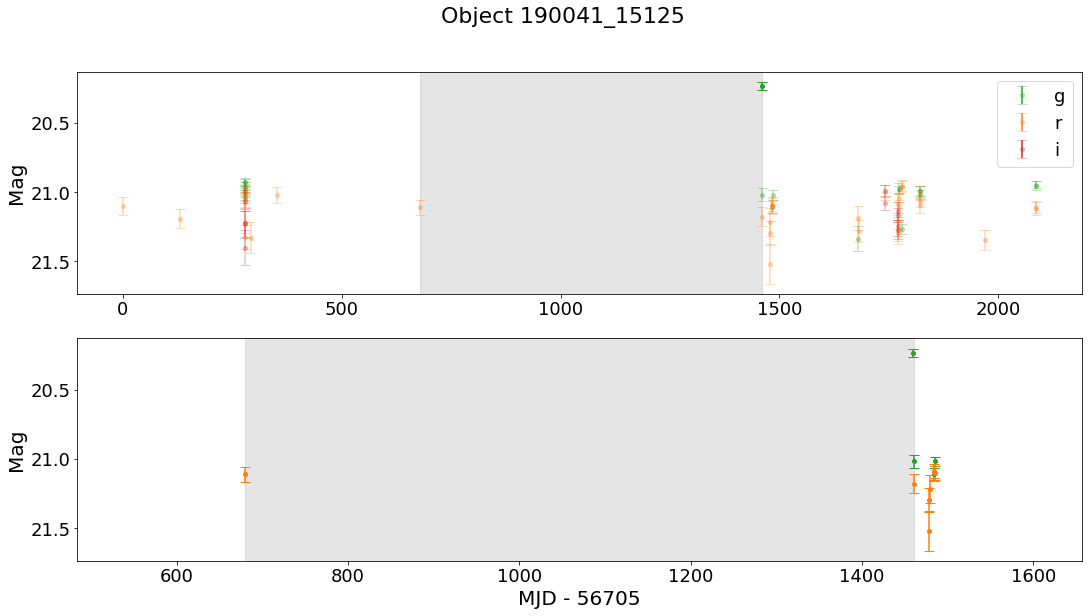

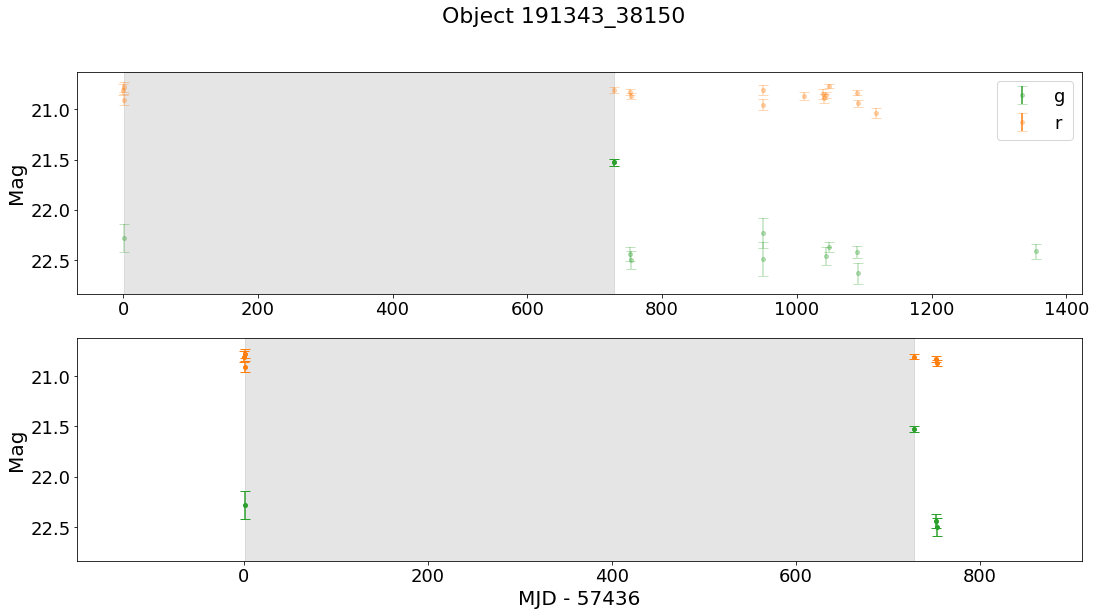

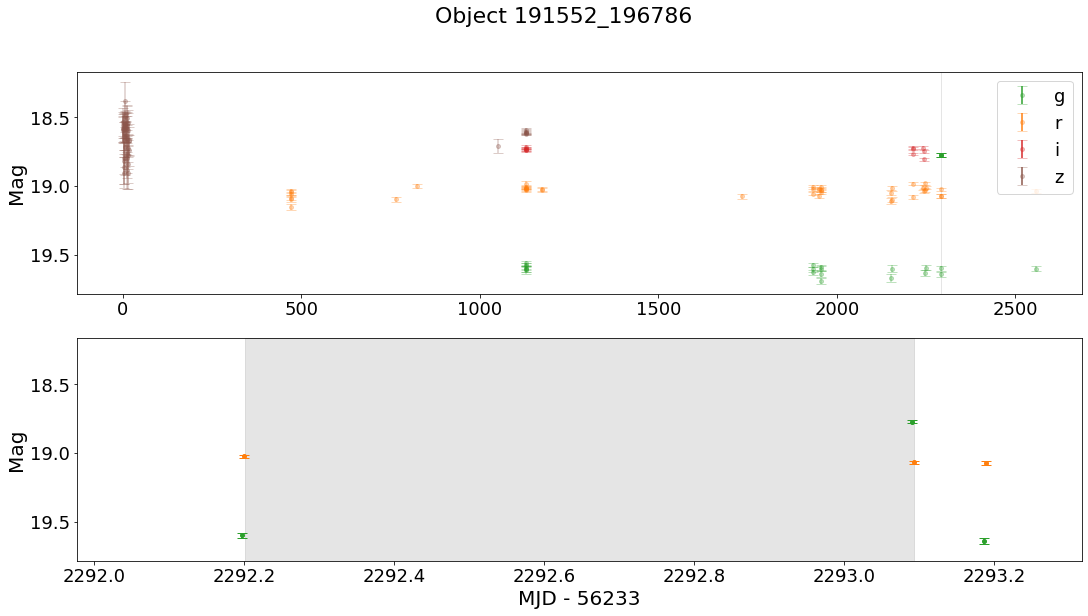

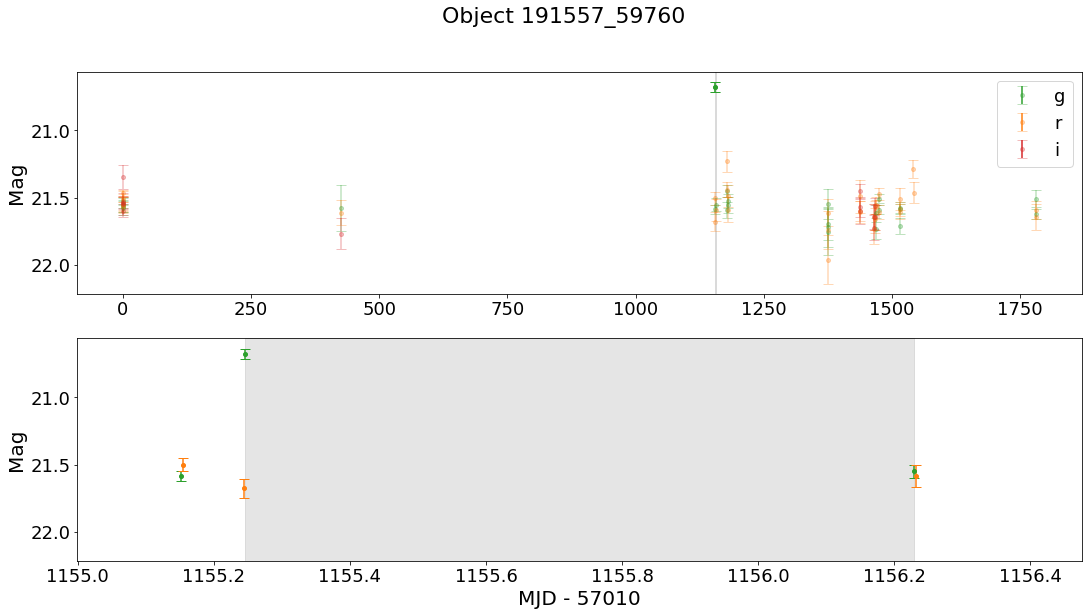

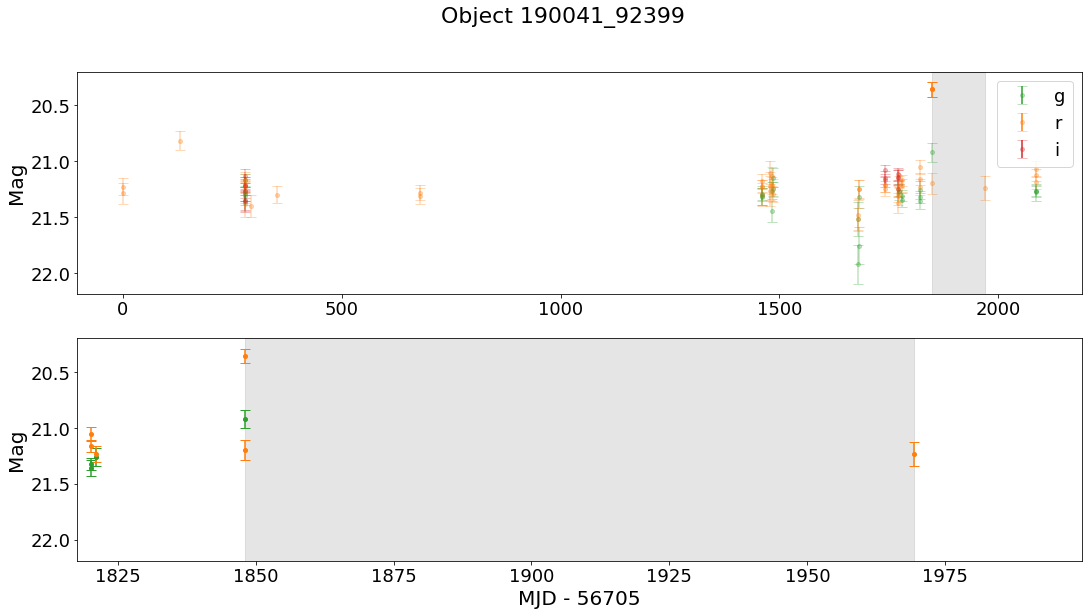

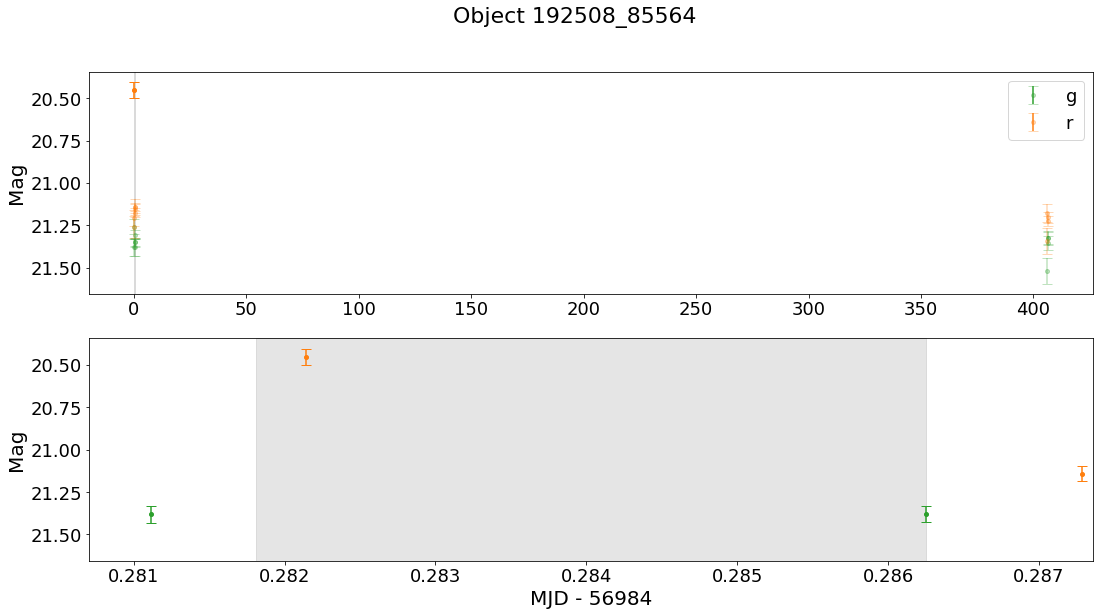

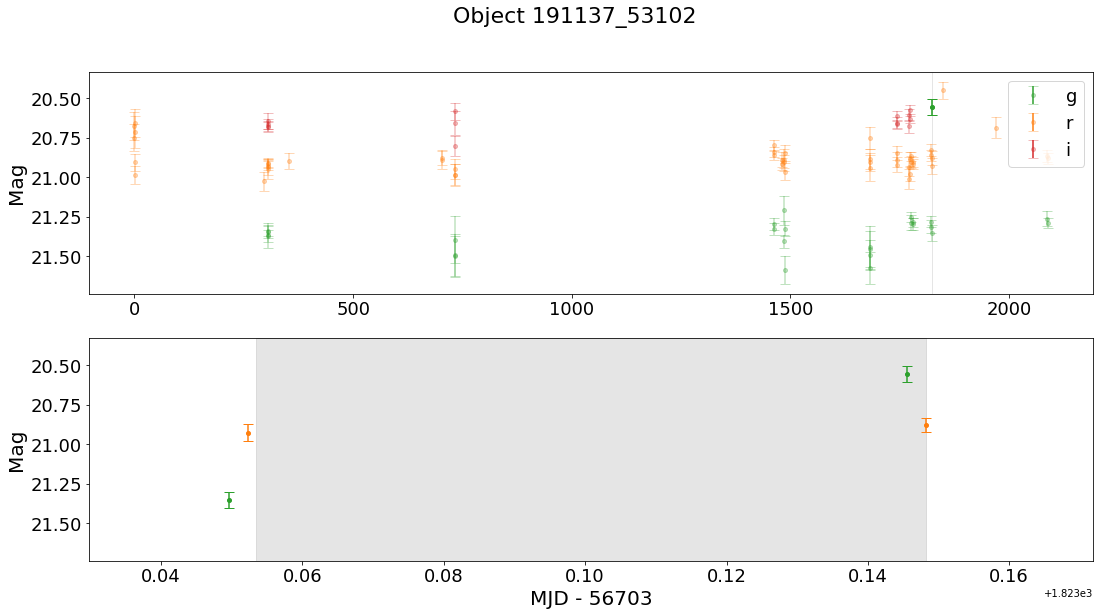

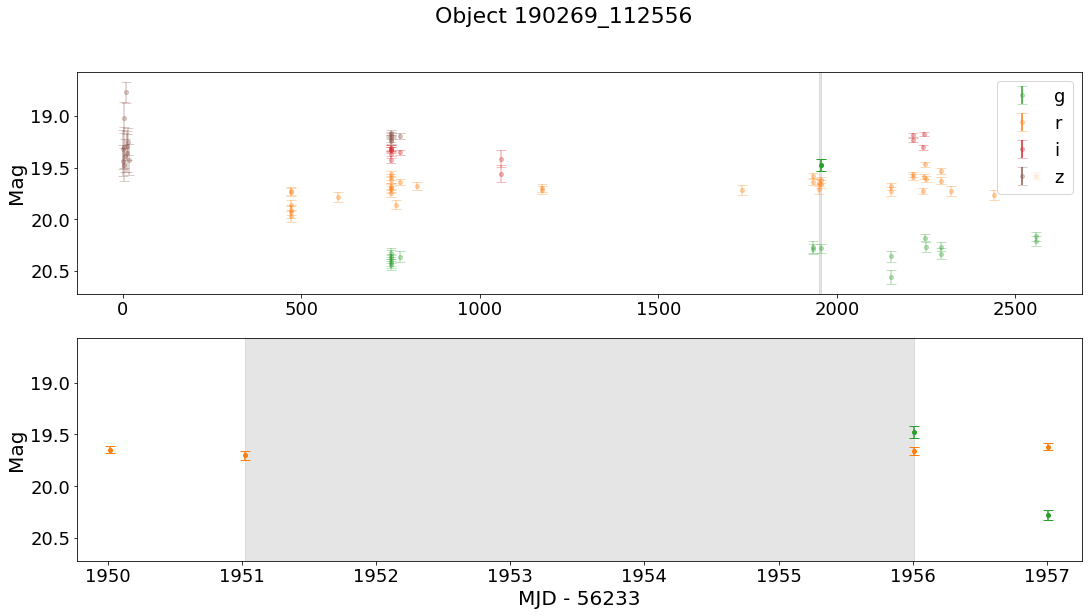

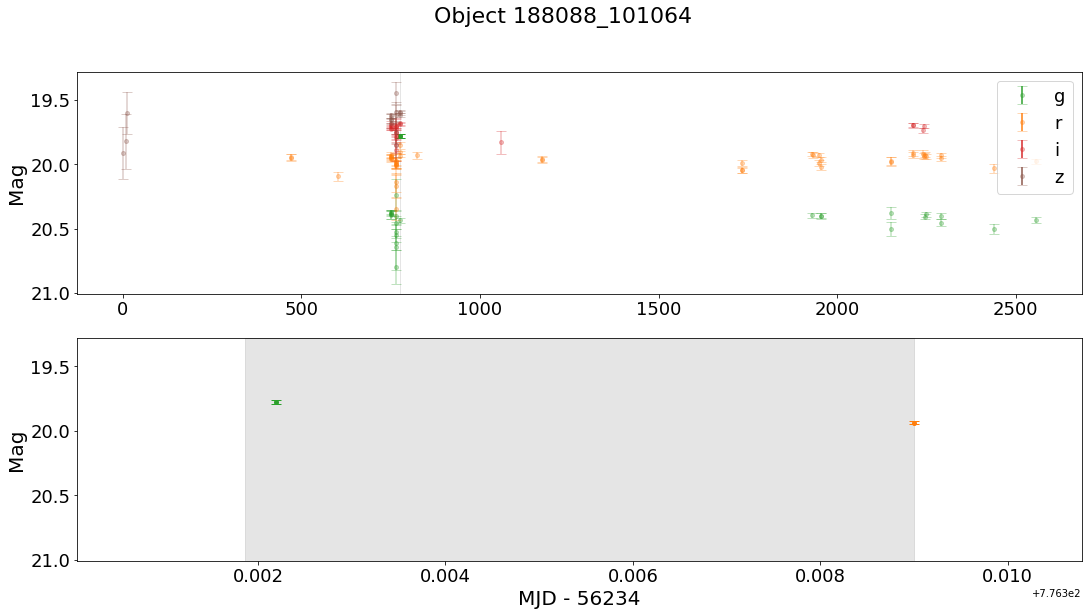

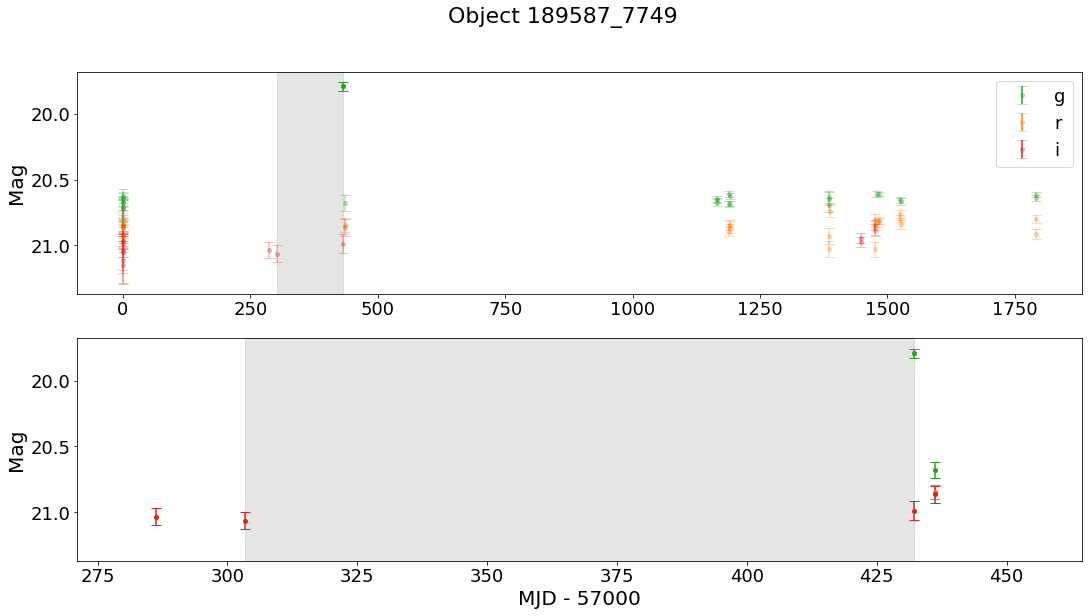

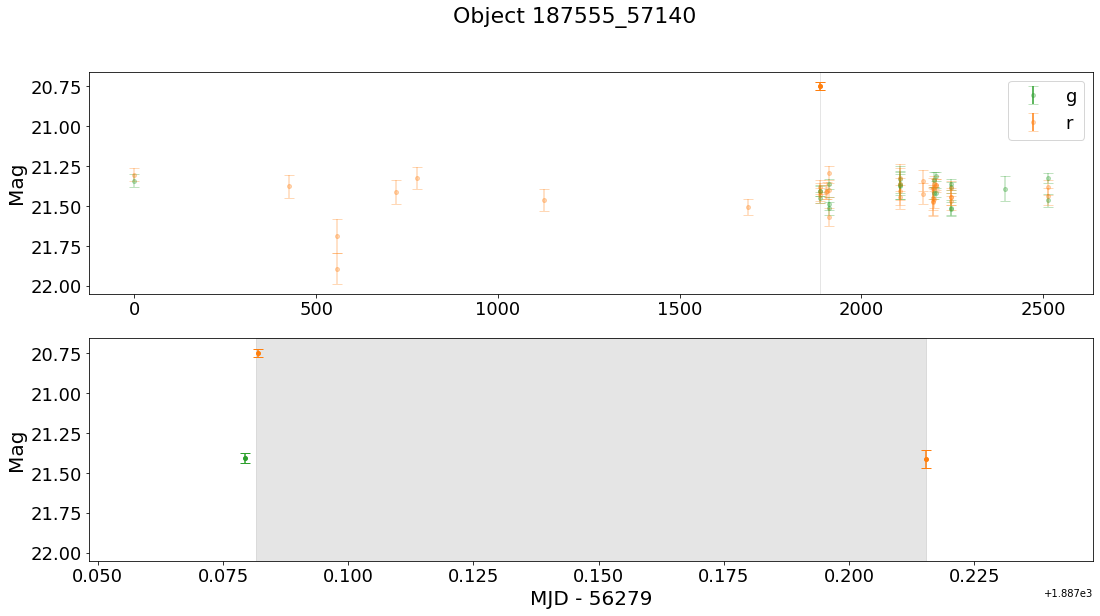

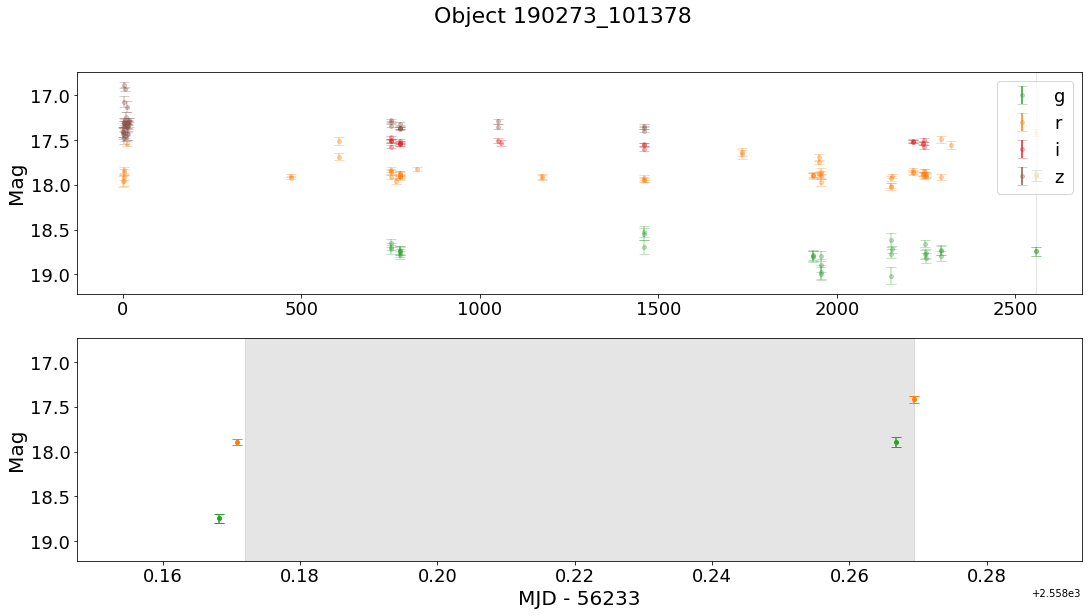

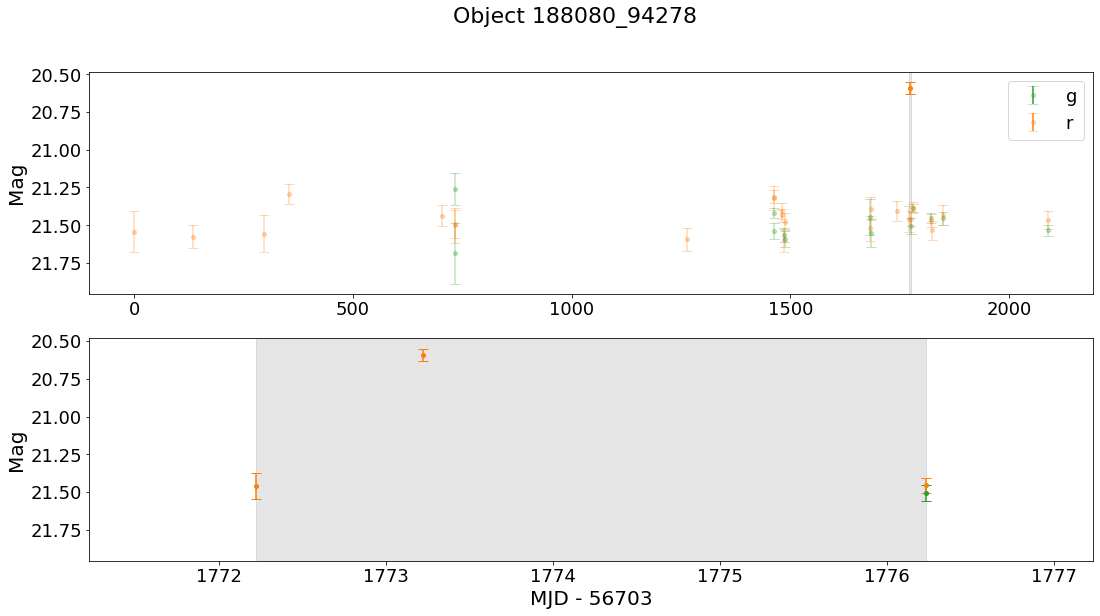

In [67]:
colors = np.array(["tab:blue", "tab:green", "tab:orange", "tab:red", "tab:brown"])
filters = np.array(['u', 'g', 'r', 'i', 'z'])

for irow in range(len(lensing_df)):
    fig, axes = plt.subplots(2, 1, figsize=(18, 9))

    row = lensing_df.iloc[irow]
    oid = row["objectid"]
    ev_start, ev_end = row["event_start"], row["event_end"]
    t_delta = ev_end - ev_start
    m_id = lightcurve_df["objectid"] == oid
    m_mjd = (lightcurve_df["mjd"] > ev_start) & (lightcurve_df["mjd"] < ev_end)
    min_mjd = int(lightcurve_df.loc[m_id, "mjd"].min())
    

    for f, c in zip(filters, colors):
        m_f = lightcurve_df["filter"] == f
        lc_lens = lightcurve_df.loc[m_id & m_f & m_mjd]
        lc_full = lightcurve_df.loc[m_id & m_f]

        if len(lc_full) > 0:
            axes[0].errorbar(lc_full["mjd"] - min_mjd, lc_full['mag_auto'], 
                             yerr=lc_full["magerr_auto"], marker='.', ms=8,
                             capsize=5, color=c, ls="None", alpha=0.3, label=f)
            axes[0].errorbar(lc_lens["mjd"] - min_mjd, lc_lens['mag_auto'], 
                             yerr=lc_lens["magerr_auto"], marker='.', ms=8,
                             capsize=5, color=c, ls="None")
            axes[1].errorbar(lc_full["mjd"] - min_mjd, lc_full['mag_auto'], 
                             yerr=lc_full["magerr_auto"], marker='.', ms=8,
                             capsize=5, color=c, ls="None")

    for ax in axes:
        ax.set_ylabel('Mag', fontsize=20)
        ax.tick_params(labelsize=18)
        ax.invert_yaxis()
        barlims = (ev_start - min_mjd, ev_end - min_mjd)
        ax.axvspan(barlims[0], barlims[1], alpha=0.2, color="tab:gray")
        
    legend = axes[0].legend(fontsize=18, loc="upper right")

    for handle in legend.legend_handles:
        handle.set_alpha(1)

    axes[1].set_xlabel(f'MJD - {min_mjd}', fontsize=20)
    tlims = ((ev_start - 0.25 * t_delta) - min_mjd, (ev_end + 0.25 * t_delta) - min_mjd)
    axes[1].set_xlim(tlims)
    fig.suptitle(f"Object {oid}", fontsize=22)

    plt.show(fig)
    plt.close(fig)

In [50]:
sub_query = f"""
SELECT id 
    FROM nsc_dr2.object
        WHERE 't' = Q3C_RADIAL_QUERY(ra, dec, {lmc_ra}, {lmc_dec}, {search_radius})
        AND class_star > 0.9
        LIMIT 100000
"""

query = f"""
SELECT objectid, mjd
    FROM nsc_dr2.meas
    WHERE objectid IN ({sub_query})
"""

# query = f"""
# SELECT M.objectid, M.mjd, E.exptime
#     FROM 
#     (SELECT * 
#         FROM nsc_dr2.meas
#         WHERE objectid IN ({sub_query})) AS M
#     INNER JOIN nsc_dr2.exposure AS E
#         ON M.exposure = E.exposure
# """

job_id = qc.query(sql=query, async_=True)
# df = qc.query(sql=query, fmt="pandas")

In [53]:
qc.status(job_id)

'COMPLETED'

In [54]:
results = qc.results(job_id)

In [55]:
results = convert(results)

In [67]:
results.sort_values(by=["objectid", "mjd"], inplace=True, ignore_index=True)

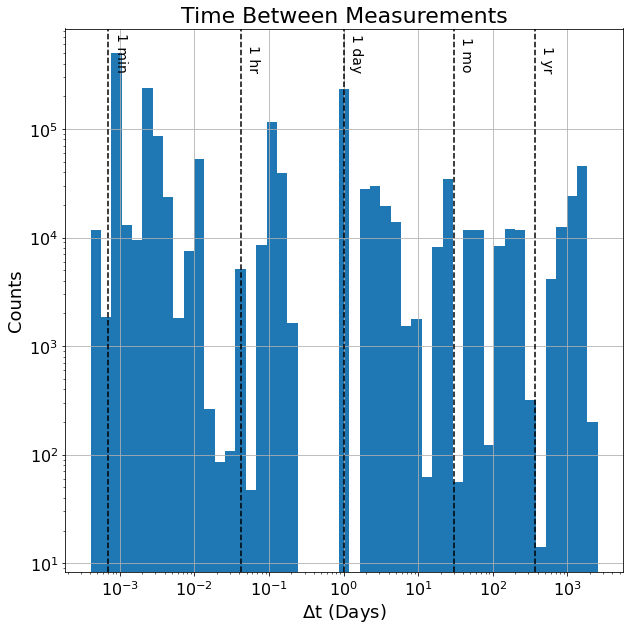

In [85]:
time_diff = results.groupby(by=["objectid"]).diff()
time_diff_bins = np.geomspace(time_diff.min().iloc[0], time_diff.max().iloc[0], num=50)

noteable_times = (np.array([60, 60 * 60, 60 * 60 * 24, 60 * 60 * 24 * 30, 60 * 60 * 24 * 365]) * u.s).to(u.day).value
time_labels = ["1 min", "1 hr", "1 day", "1 mo", "1 yr"]

fig, ax = plt.subplots(figsize=(10, 10))
time_diff.hist(grid=True, ax=ax, bins=time_diff_bins, log=True)

ax.tick_params(labelsize=16)
ax.set_title("Time Between Measurements", fontsize=22)
ax.set_xlabel(r"$\Delta$t (Days)", fontsize=18)
ax.set_ylabel("Counts", fontsize=18)
ax.set_xscale("log")

blended_transform = ax.get_xaxis_transform()
axis_transform = ax.transAxes
axis_transform_inverse = axis_transform.inverted()

for t, l in zip(noteable_times, time_labels):
    ax.axvline(t, ls="--", color='k')
    (x, y) = axis_transform_inverse.transform(blended_transform.transform((t, 0.925)))
    ax.text(x+0.01, y, l, fontsize=14, transform=axis_transform, rotation=-90)

plt.show(fig)
fig.savefig(f"{fig_dir}delta_t_hist.png")

In [72]:
lensed_ids = lensing_df["objectid"].unique()

def baseline_weighted_std(df):
    m = df["cluster_label"] == 1
    samples = df.loc[m, "mag_auto"].values
    weights = np.power(df.loc[m, "magerr_auto"].values, -2)
    result = datalab_utils.weighted_std(samples, weights)
    return result

sigmas = []

for oid in lensed_ids:
    m_id = lightcurve_df["objectid"] == oid
    cluster_labelled_df = datalab_utils.cluster_label_dataframe(lightcurve_df.loc[m_id], kde_bandwidth=bw)
    sigmas.append(cluster_labelled_df.groupby("filter").apply(baseline_weighted_std))
    
sigmas = pd.concat(sigmas)
(sigmas < np.log10(1.7) / 2).all()

True

In [4]:
# oid = lensing_df.iloc[0]["objectid"]
# # plot_lightcurve_basic(lightcurve_df, oid)
# m_id = lightcurve_df["objectid"] == oid
# bw2 = 2.5 * np.log10(2) / 4
# for fil in lightcurve_df.loc[m_id, "filter"].unique():
#     print(fil)
#     fig, ax = plt.subplots(figsize=(10, 10))
#     m_f = lightcurve_df["filter"] == fil
#     m = m_id & m_f
#     samples = lightcurve_df.loc[m, "mag_auto"].values
#     weights = np.power(lightcurve_df.loc[m, "magerr_auto"].values, -2)
#     kde_result = datalab_utils.kde_pdf(samples, weights, bw2)
#     print(datalab_utils.detect_bimodal(kde_result))
#     print(datalab_utils.label_cluster_membership(samples, kde_result))
#     pdf, x = kde_result["pdf"], kde_result["x"]
#     ax.plot(x, pdf)
#     ax.scatter(samples, np.full(samples.shape, 0))
#     plt.show(fig)
# # lightcurve_df.loc[m_id]

In [48]:
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/nsc_dr2"
svc = sia.SIAService(DEF_ACCESS_URL)

object_id = trigger_ids[6]
mask_object_id = lightcurve_df["objectid"] == object_id
object_id_str = str(object_id).replace('.', '-')
filt = lightcurve_df.loc[mask_excursion & mask_object_id, "filter"].iloc[0]
mask_object_filter = lightcurve_df["filter"] == filt

obs_dates = np.round(lightcurve_df.loc[mask_object_id & mask_object_filter, "mjd"], decimals=8).astype(str)

image_ra = lightcurve_df.loc[mask_excursion & mask_object_id, "ra"].iloc[0]
image_dec = lightcurve_df.loc[mask_excursion & mask_object_id, "dec"].iloc[0]
image_fov = 0.002

imgTable = svc.search((image_ra, image_dec), 
                      (image_fov/np.cos(image_dec*np.pi/180), 
                       image_fov), verbosity=2).to_table()  # uses declination correction

select_filter = imgTable["obs_bandpass"] == filt
select_mjd = np.isin(imgTable["mjd_obs"].data.data, obs_dates)
select_proctype = imgTable["proctype"] == "InstCal"
select_prodtype = imgTable["prodtype"] == "image"
subTable = imgTable[select_filter & select_proctype & select_prodtype]
l = np.array([[eid in url for url in subTable["access_url"]] 
              for eid in lightcurve_df.loc[mask_object_filter & mask_object_id, "exposure"]])
select_exposure_id = l.any(axis=0)
table = subTable[select_exposure_id]
table

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
ct4m20181224t054503,"https://datalab.noirlab.edu/svc/cutout?col=nsc_dr2&siaRef=c4d_181224_054503_ooi_i_v1.fits.fz&extn=7&POS=81.18194498196017,-69.92181425483746&SIZE=0.005825772222387716,0.002",image/fits,347928,,,2,0,0,2,[24 4094],,,[-0.12487],,ct4m20181224t054503,,2018A-0273,archival,,,DECam,i,,,ivo://datalab.noirlab/vo#ivoa_nsc_dr2.siav1:ivo://datalab.noao//c4d_181224_054503_ooi_i_v1.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=nsc_dr2&siaRef=c4d_181224_054503_ooi_i_v1.fits.fz&extn=7&POS=81.18194498196017,-69.92181425483746&SIZE=0.005825772222387716,0.002&preview=true",,,81.6117,-69.9691,--,,,--,7100.0,8570.0,--,--,--,--,--,--,,,,PALS field: 15413-01-i,1.37,2018A-0273,31.281,image,0,0,,200,,InstCal,2018-12-24T05:45:03.606132,58476.23962507,0
ct4m20181223t054413,"https://datalab.noirlab.edu/svc/cutout?col=nsc_dr2&siaRef=c4d_181223_054413_ooi_i_v1.fits.fz&extn=7&POS=81.18194498196017,-69.92181425483746&SIZE=0.005825772222387716,0.002",image/fits,346485,,,2,0,0,2,[24 4094],,,[-0.12486],,ct4m20181223t054413,,2018A-0273,archival,,,DECam,i,,,ivo://datalab.noirlab/vo#ivoa_nsc_dr2.siav1:ivo://datalab.noao//c4d_181223_054413_ooi_i_v1.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=nsc_dr2&siaRef=c4d_181223_054413_ooi_i_v1.fits.fz&extn=7&POS=81.18194498196017,-69.92181425483746&SIZE=0.005825772222387716,0.002&preview=true",,,81.6147,-69.9684,--,,,--,7100.0,8570.0,--,--,--,--,--,--,,,,PALS field: 15413-01-i,1.37,2018A-0273,31.273,image,0,0,,200,,InstCal,2018-12-23T05:44:13.952910,58475.23905038,0
ct4m20181224t032645,"https://datalab.noirlab.edu/svc/cutout?col=nsc_dr2&siaRef=c4d_181224_032645_ooi_i_v1.fits.fz&extn=7&POS=81.18194498196017,-69.92181425483746&SIZE=0.005825772222387716,0.002",image/fits,347397,,,2,0,0,2,[24 4094],,,[-0.12485],,ct4m20181224t032645,,2018A-0273,archival,,,DECam,i,,,ivo://datalab.noirlab/vo#ivoa_nsc_dr2.siav1:ivo://datalab.noao//c4d_181224_032645_ooi_i_v1.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=nsc_dr2&siaRef=c4d_181224_032645_ooi_i_v1.fits.fz&extn=7&POS=81.18194498196017,-69.92181425483746&SIZE=0.005825772222387716,0.002&preview=true",,,81.5589,-69.9888,--,,,--,7100.0,8570.0,--,--,--,--,--,--,,,,PALS field: 15413-01-i,1.32,2018A-0273,31.321,image,0,0,,200,,InstCal,2018-12-24T03:26:45.154752,58476.14357818,0
ct4m20181125t074331,"https://datalab.noirlab.edu/svc/cutout?col=nsc_dr2&siaRef=c4d_181125_074331_ooi_i_v1.fits.fz&extn=7&POS=81.18194498196017,-69.92181425483746&SIZE=0.005825772222387716,0.002",image/fits,349050,,,2,0,0,2,[24 4094],,,[-0.12486],,ct4m20181125t074331,,2018A-0273,archival,,,DECam,i,,,ivo://datalab.noirlab/vo#ivoa_nsc_dr2.siav1:ivo://datalab.noao//c4d_181125_074331_ooi_i_v1.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=nsc_dr2&siaRef=c4d_181125_074331_ooi_i_v1.fits.fz&extn=7&POS=81.1

Exposure time: 60s, Field41


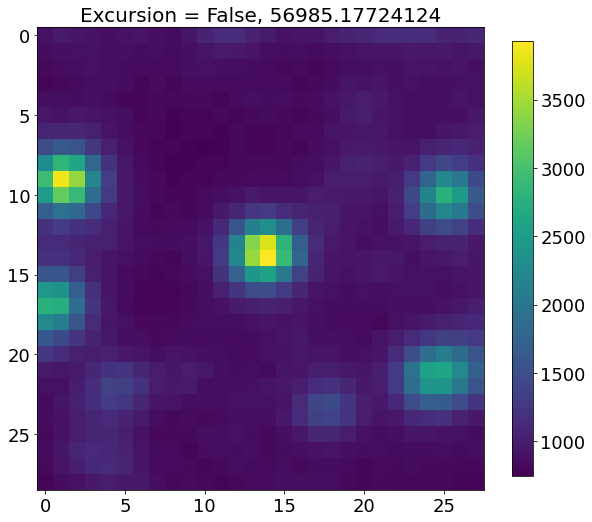

Exposure time: 60s, Field41


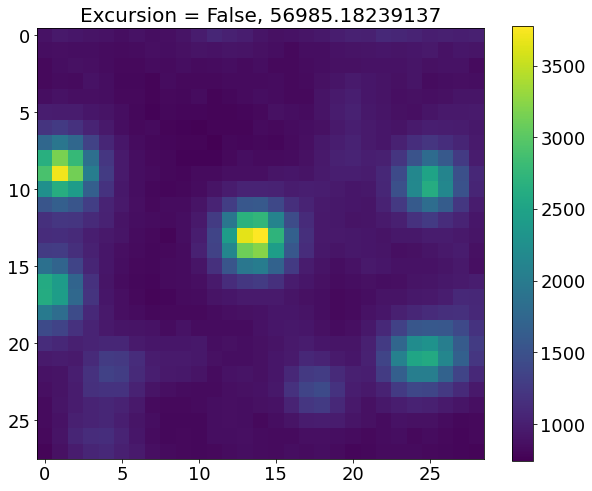

Exposure time: 333s, Field41


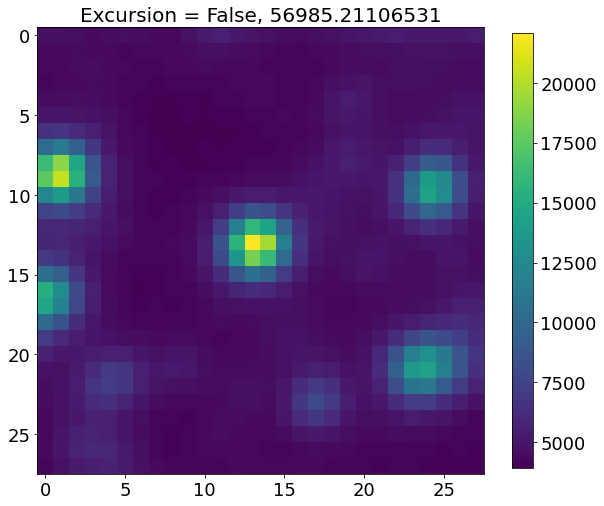

Exposure time: 333s, Field41


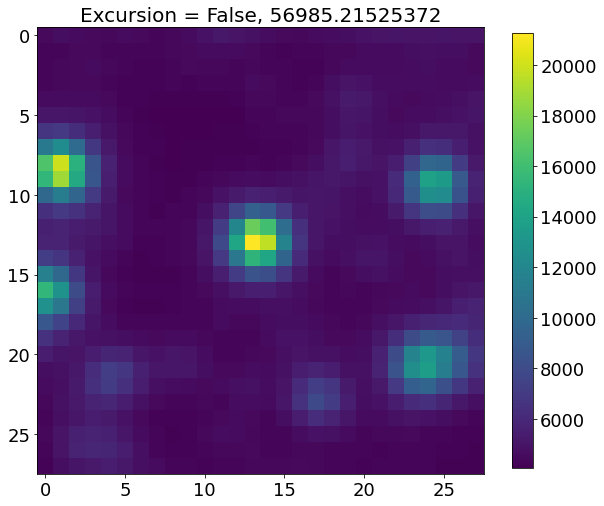

Exposure time: 5s, DES wide hex 790--700


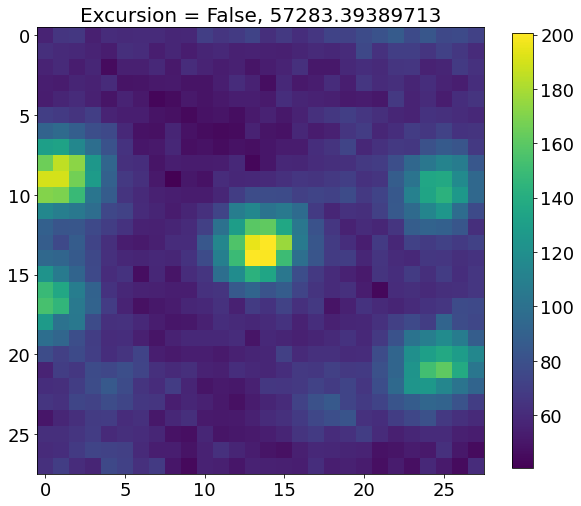

Exposure time: 5s, DESGW: LIGO event G184098-lmc-2: 8 of 14


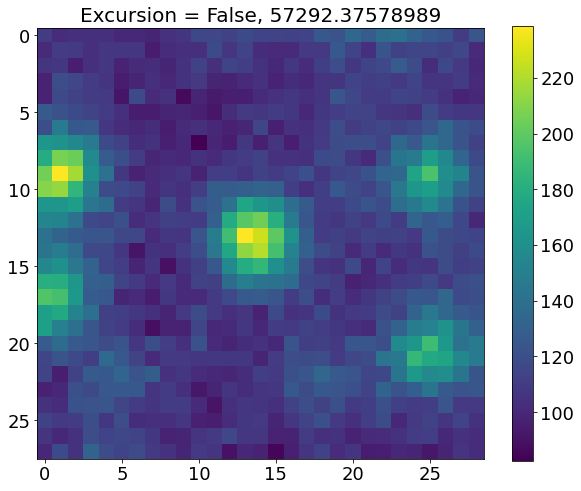

Exposure time: 200s, PALS field: 15413-01-i


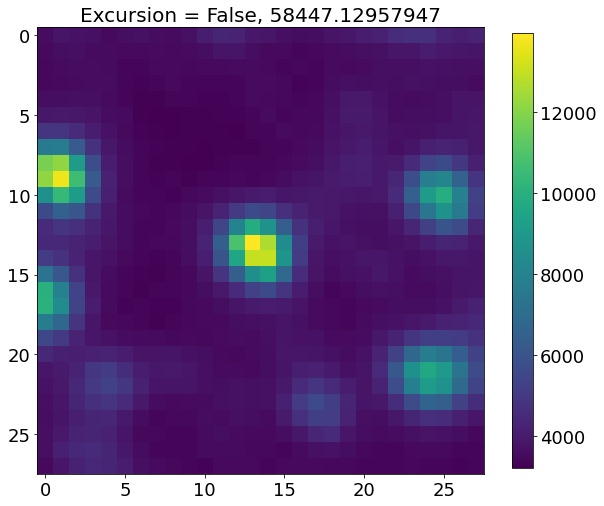

Exposure time: 200s, PALS field: 15400-01-i


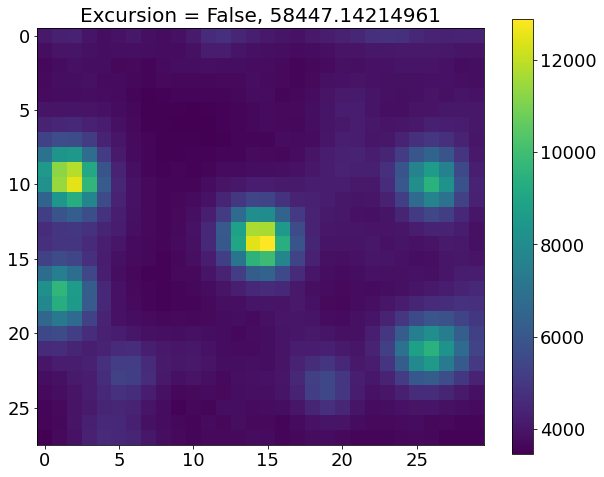

Exposure time: 200s, PALS field: 15400-01-i


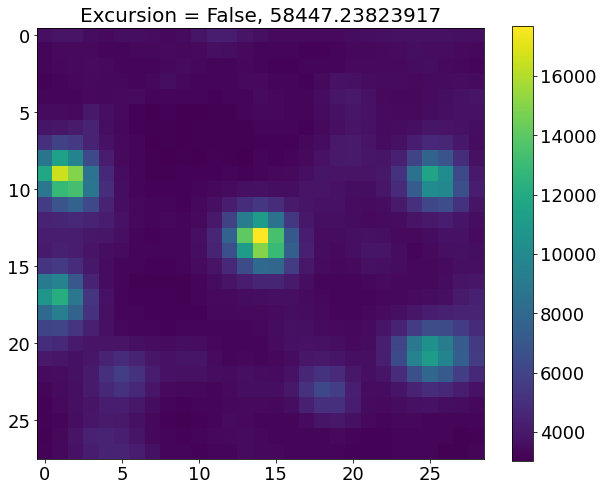

Exposure time: 200s, PALS field: 15413-01-i


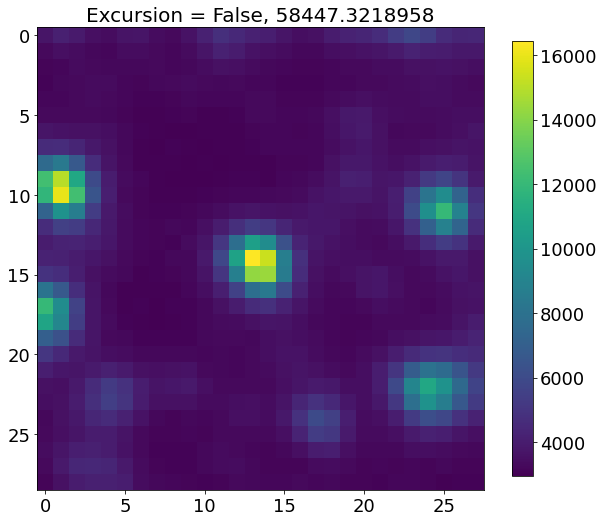

Exposure time: 200s, PALS field: 15400-01-i


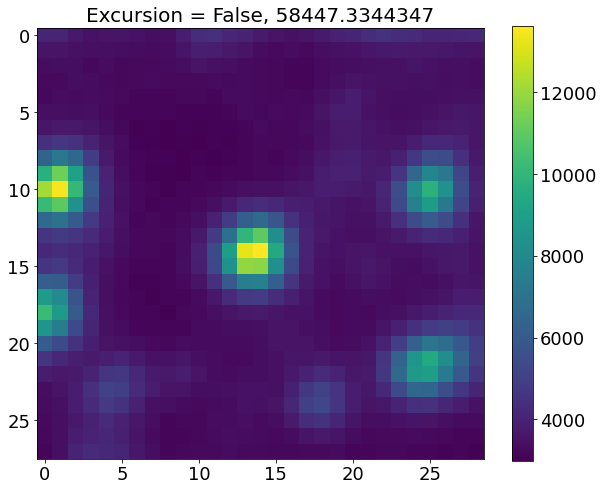

Exposure time: 200s, PALS field: 15400-01-i


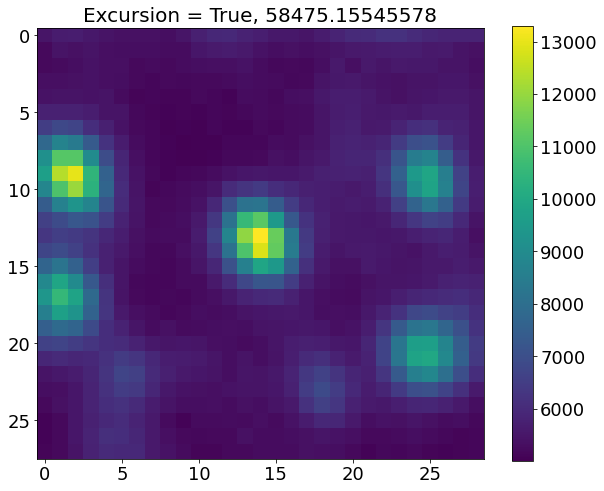

Exposure time: 200s, PALS field: 15413-01-i


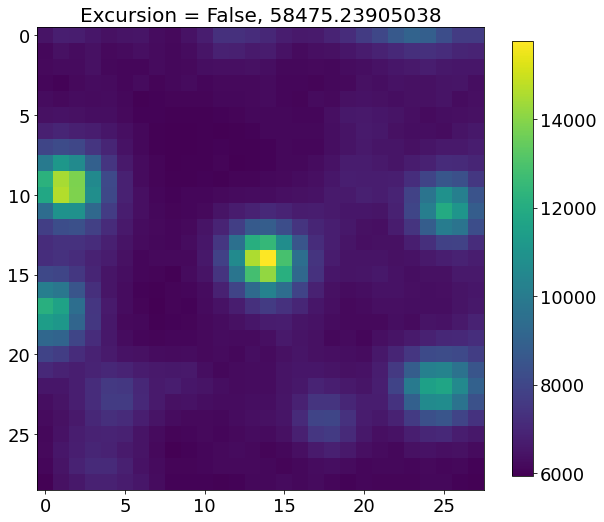

Exposure time: 200s, PALS field: 15400-01-i


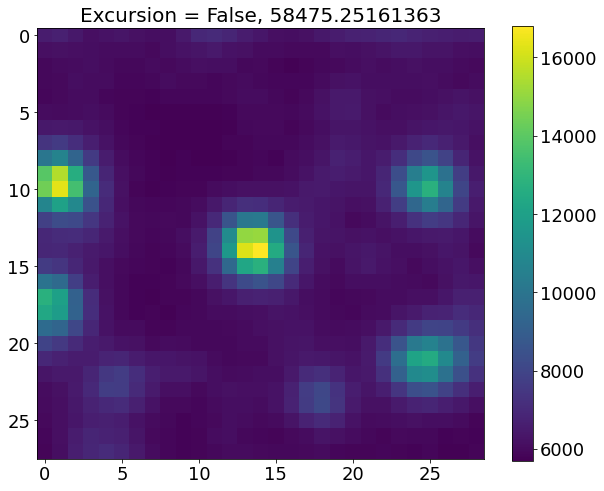

Exposure time: 200s, PALS field: 15413-01-i


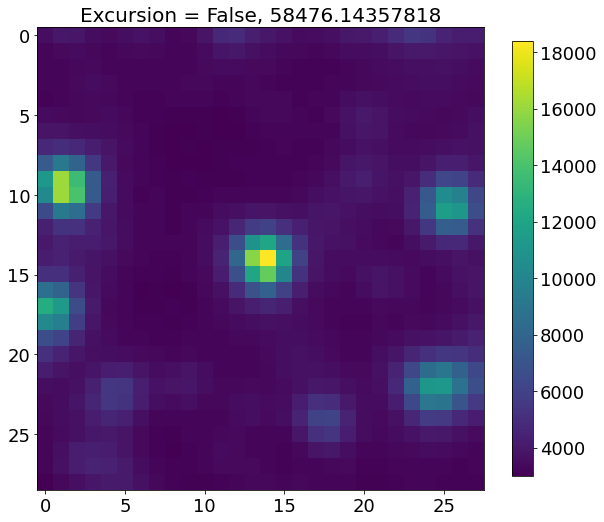

Exposure time: 200s, PALS field: 15400-01-i


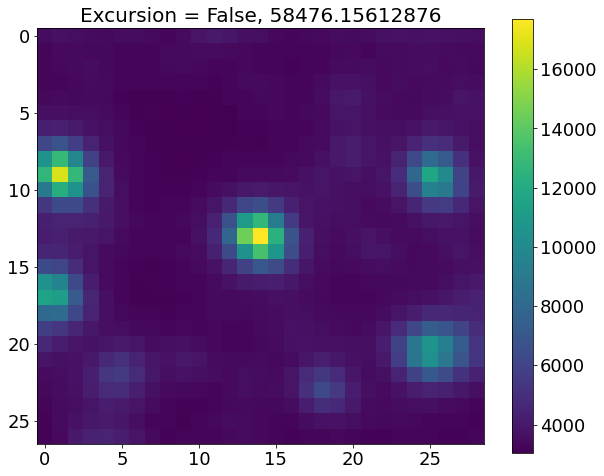

Exposure time: 200s, PALS field: 15413-01-i


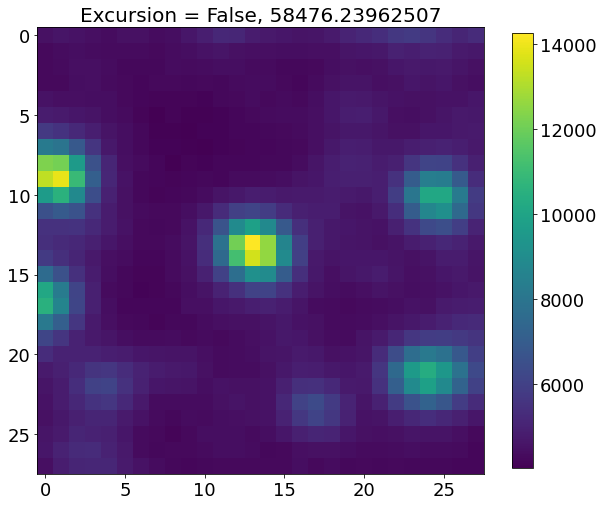

In [67]:
images = []
exposure_times = []
excursion_list = []
object_lc_df = lightcurve_df.loc[mask_object_id & mask_object_filter]
for date in np.sort(table["mjd_obs"].data.data):
    row = table[table["mjd_obs"] == date][0]
    url = row["access_url"]
    field = row["object"]
    mask_expnum = [enum in url for enum in object_lc_df["exposure"]]
    excursion = object_lc_df.loc[mask_expnum, "excursion"].iloc[0]
    exposure_time = row["exptime"]
    print(f"Exposure time: {exposure_time}s, {field}")
    file = utils.data.download_file(url, cache=True, timeout=300)
    im = io.fits.getdata(file)
    fig, ax = plt.subplots(figsize=(10, 10))
    axim = ax.imshow(im)
    cbar = fig.colorbar(axim, ax=ax, shrink=0.8)
    ax.tick_params(labelsize=18)
    ax.set_title(f"Excursion = {excursion}, {date}", fontsize=20)
    cbar.ax.tick_params(labelsize=18)
    images.append(im)
    exposure_times.append(exposure_time)
    excursion_list.append(excursion)
    plt.show(fig)

60


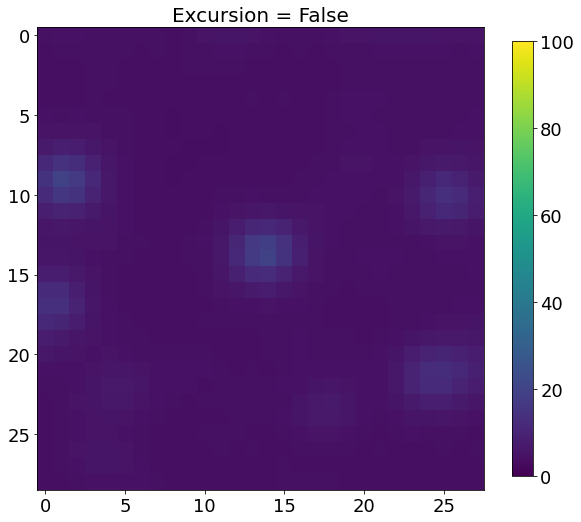

60


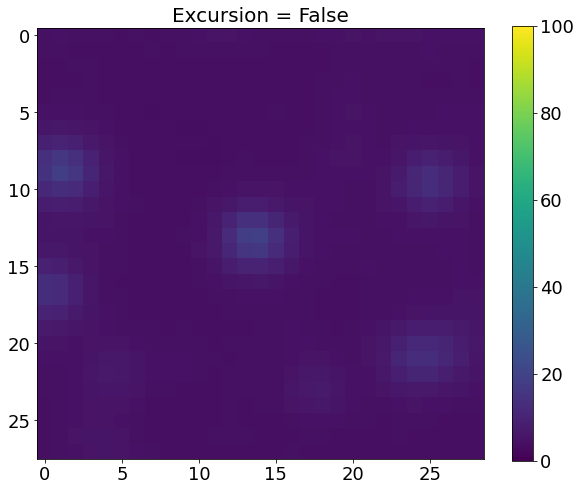

333


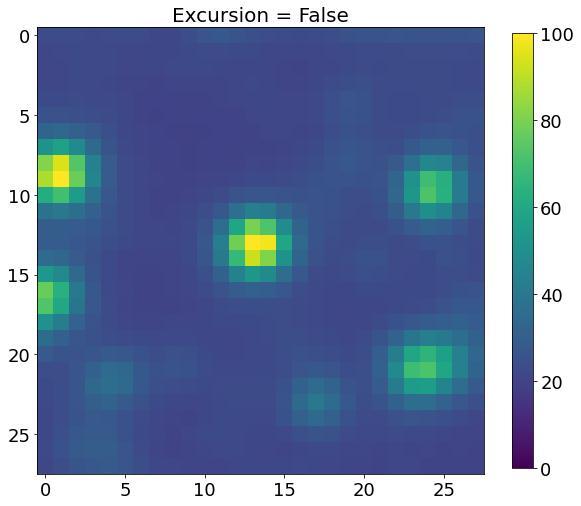

333


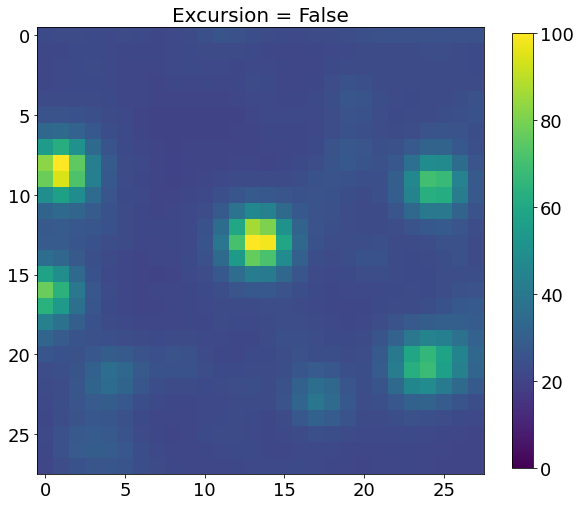

5


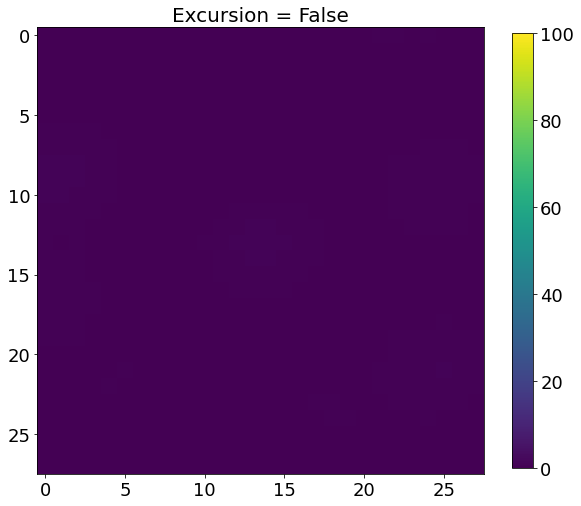

5


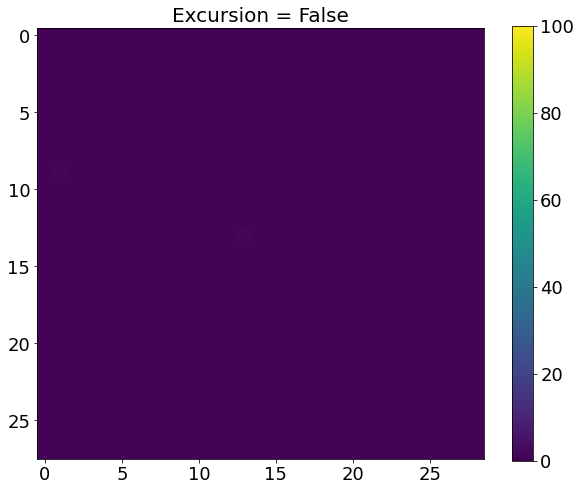

200


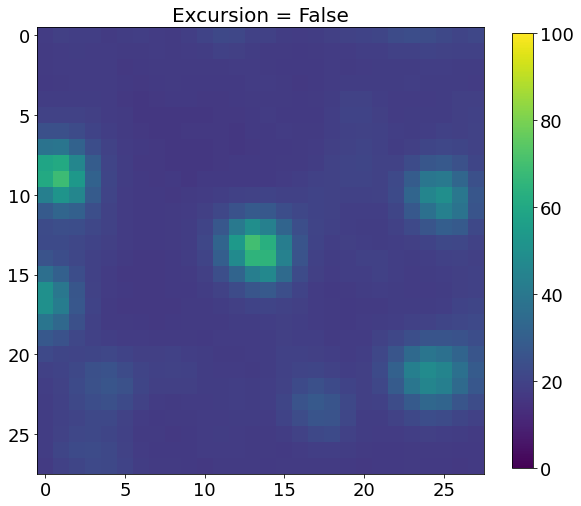

200


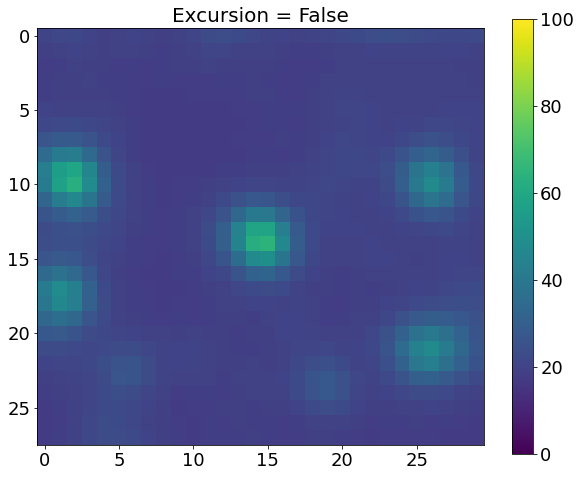

200


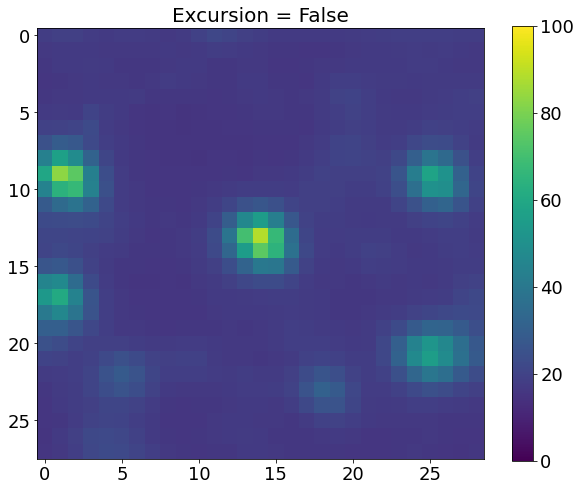

200


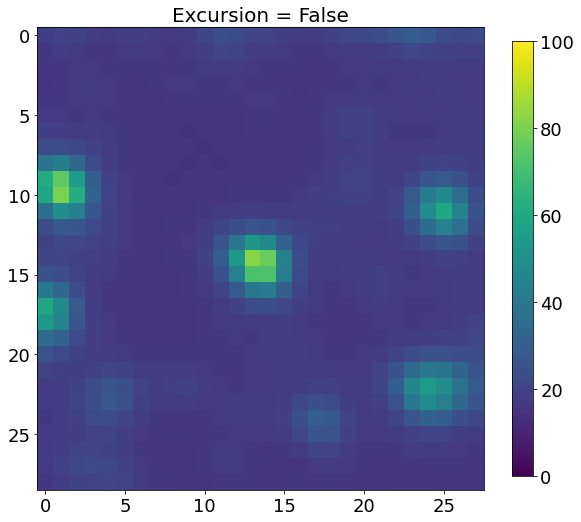

200


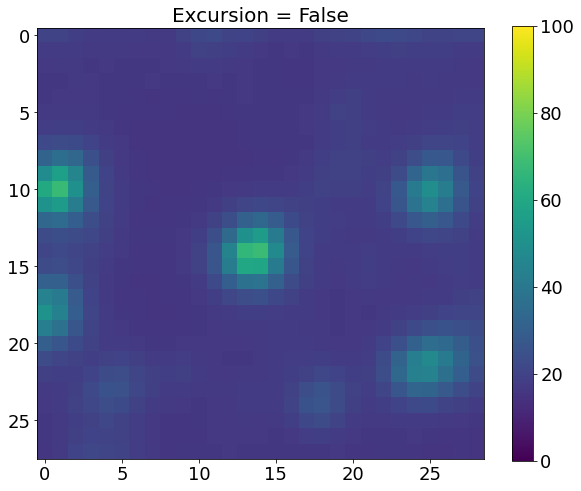

200


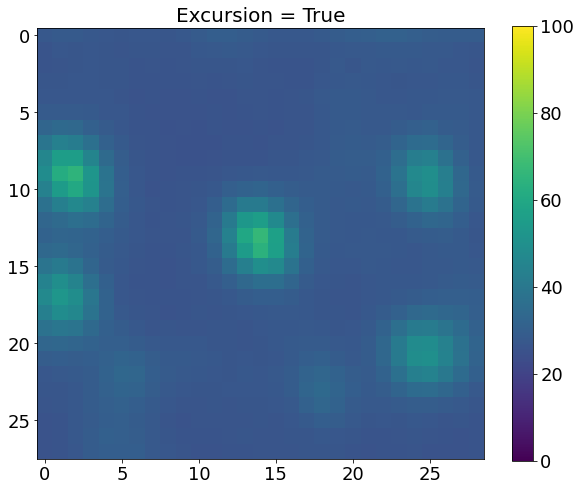

200


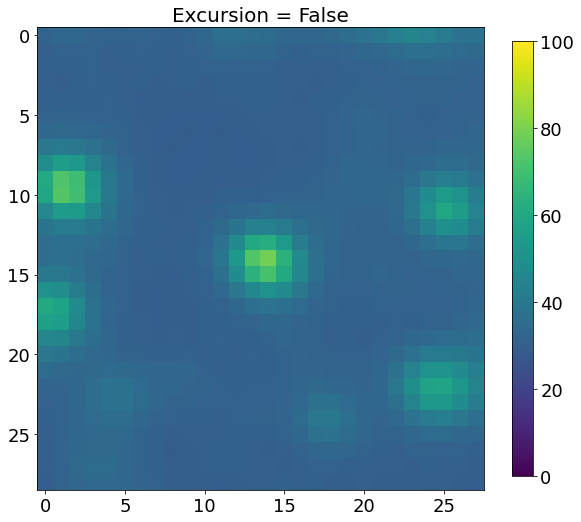

200


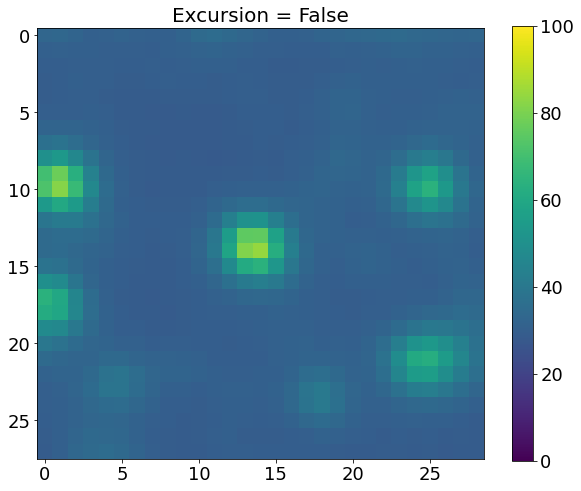

200


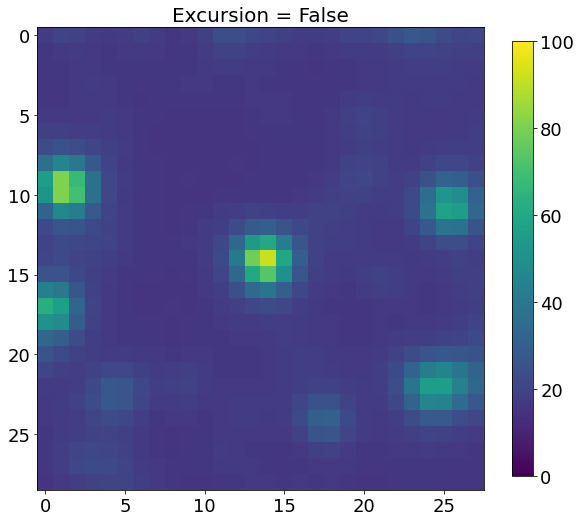

200


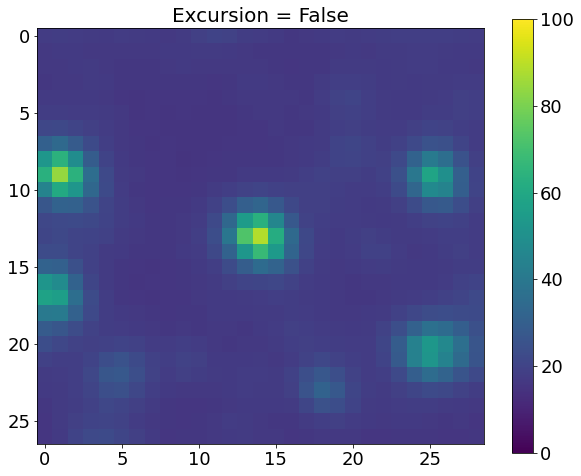

200


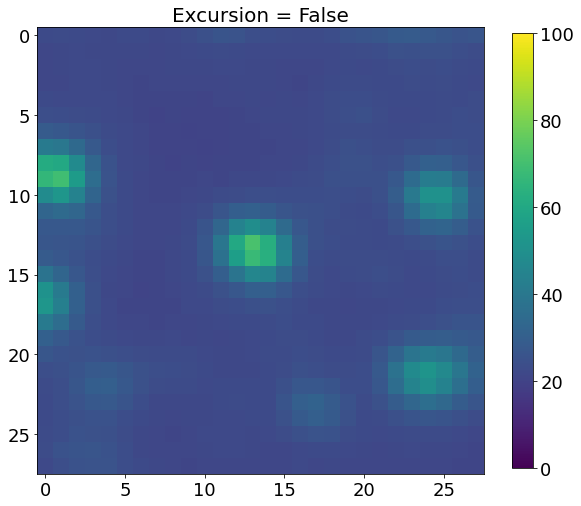

In [58]:
for im, exptime, exc in zip(images, exposure_times, excursion_list):
    print(exptime)
    im0 = im / int(exposure_time)
    fig, ax = plt.subplots(figsize=(10, 10))
    axim = ax.imshow(im0, vmin=0, vmax=100)
    cbar = fig.colorbar(axim, ax=ax, shrink=0.8)
    ax.tick_params(labelsize=18)
    ax.set_title(f"Excursion = {exc}", fontsize=20)
    cbar.ax.tick_params(labelsize=18)
    plt.show(fig)
#     fig.savefig(f"{fig_dir}{object_id_str}_image_exptime_scaled{i}.png")